# Analysis of Single-cell RNA-seq data (Python)

Understand a general workflow for dealing with scRNA-seq data
* Quality control
* Normalization
* Dimensionality reduction
* Clustering
* Cell annotate

### Download the dataset
To give you hands-on experience analyzing a single-cell RNASeq dataset we will be using data from **Cao et al** as an example.

In [ ]:
#accession number GSE119945
#!mkdir datasets
#!mkdir results
#!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE119nnn/GSE119945/suppl/GSE119945%5Fgene%5Fcount%2Etxt%2Egz
#!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE119nnn/GSE119945/suppl/GSE119945%5Fgene%5Fannotate%2Ecsv%2Egz
#!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE119nnn/GSE119945/suppl/GSE119945%5Fcell%5Fannotate%2Ecsv%2Egz

With data in place, now we can start loading libraries we will use later.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
# verbosity: errors (0), warnings (1), info (2), hints (3)

### Load the dataset

In [ ]:
# MOCAdata=sc.read_mtx('/gpfs/ysm/project/my393/Assignment4-scRNA/GSE119945_gene_count.txt.gz').T
# MOCAdata.obs_names=pd.read_csv('/gpfs/ysm/project/my393/Assignment4-scRNA/GSE119945_cell_annotate.csv.gz', header=None)[0].values
# MOCAdata.var_names=pd.read_csv('/gpfs/ysm/project/my393/Assignment4-scRNA/GSE119945_gene_count.txt.gz', header=None,sep='\t')[1].values

In [2]:
data_path_prefix = '/Users/Mingyu/Desktop/Assignment4-scRNA/datasets'
results_path_prefix = '/Users/Mingyu/Desktop/Assignment4-scRNA/results'

### Building an AnnData object

Anndata stands for "annotated data," and is the standard format used by the analysis library, SCANPY.

Data structure: AnnData
* they refer to cells as **observations** and genes as **variables**.

For example:
* MOCAdata.X stores the count matrix
* MOCAdata.obs stores metadata about the observations (cells)
* MOCAdata.var stores metadata about the variables (genes)
* MOCAdata.uns stores unstructured annotations

<img src="https://falexwolf.de/img/scanpy/anndata.svg" width="500px" align=left />)

In [3]:
MOCAdata = sc.read_10x_mtx(
    data_path_prefix,
    var_names='gene_symbols',
    cache=True)

... reading from cache file cache/Users-Mingyu-Desktop-Assignment4-scRNA-datasets-matrix.h5ad


In [ ]:
MOCAdata

In [ ]:
#sc.pp.subsample(MOCAdata,fraction=0.5)

### Calculate QC

Having the data in a suitable format, we can start calculating some quality metrics. For example, we can calculate the percentage of mitocondrial genes per cell and add to the metadata.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): "High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."

Scanpy calculate general qc-stats for genes and cells with the function sc.pp.calculate_qc_metrics. It can also calculate proportion of counts for specific gene populations, so first we need to define which genes are mitochondrial.

In [4]:
# mitochondrial genes
MOCAdata.var['mt'] = MOCAdata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(MOCAdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

### Plot QC

Now we can plot some of the QC-features as violin plots.

The violin plot measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

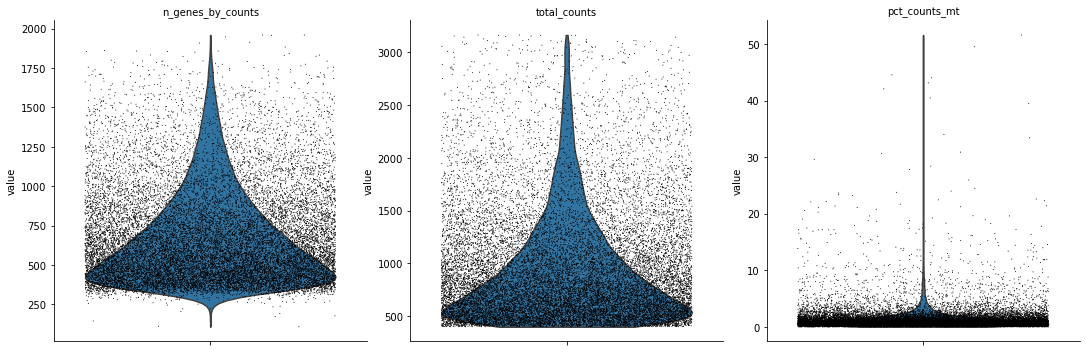

In [5]:
sc.pl.violin(MOCAdata, 
             ['n_genes_by_counts', 'total_counts','pct_counts_mt'],
             jitter=0.4, 
             multi_panel=True)

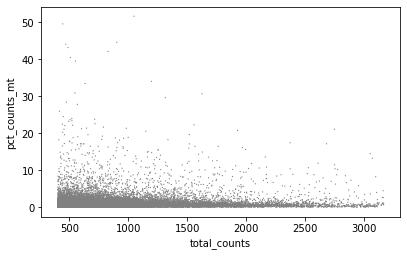

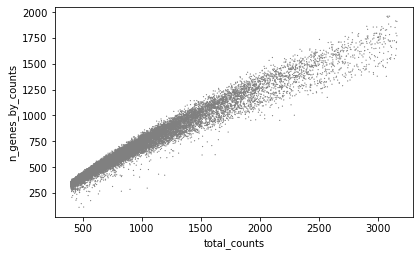

In [6]:
sc.pl.scatter(MOCAdata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(MOCAdata, x='total_counts', y='n_genes_by_counts')

### Filtering
1. A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. For example, only consider cells with at least 200 detected genes and genes need to be expressed in at least 3 cells.  (Please note that those values are highly dependent on the library preparation method used.)

In [ ]:
# sc.pp.filter_cells(MOCAdata, min_genes=200)
# sc.pp.filter_genes(MOCAdata, min_cells=3)

2. Extremely high number of detected genes could indicate doublets. The dataset we download are already filtered the doublet, so we will skip this step now, but the code below is an example of how it can be run:

In [ ]:
# MOCAdata = MOCAdata[MOCAdata.obs.n_genes_by_counts < 2000, :] # used to filter doublet

3. Filter for percent mitochondrial

In [ ]:
# MOCAdata = MOCAdata[MOCAdata.obs.pct_counts_mt < 10, :]

 * Sample sex (use biomart to fetch chromosome information)
 * Calculate cell-cycle scores, 
 * Predict doublets (use Scrublet package))

### Normalizing gene expression



Single cell data is messy. It often contains noise from technical artifacts, batch effects, and other confounders. Before analyzing data, we need to assess and correct for as much of this unwanted variation as possible. We first need to normalize and then log-transform after adding a pseudocount. 

Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [7]:
# normalize to depth 10,000
sc.pp.normalize_total(MOCAdata, target_sum=1e4) 

normalizing counts per cell
    finished (0:00:00)


We then take the log(1+x) of each value. The +1 makes sure that 0 values in the original data still map to 0 in log space. This makes the expression values more closely approximate a Gaussian distribution, which is an assumption inherent to many downstream analysis methods.

In [8]:
#logaritmize
sc.pp.log1p(MOCAdata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. 

In [9]:
# store normalized counts in the raw slot, 
# we will subset MOCAdata.X for variable genes, but want to keep all genes matrix as well.
MOCAdata.raw = MOCAdata

Let's take a look at the current AnnData.

In [10]:
MOCAdata

AnnData object with n_obs × n_vars = 20000 × 26183
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

Next, The top 2,000 genes with the highest variance were selected according to the paper.

In [11]:
# compute variable genes
sc.pp.highly_variable_genes(MOCAdata, 
                            n_top_genes = 2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
# plot variable genes
# sc.pl.highly_variable_genes(MOCAdata)

In this step, we store the subset for variable genes into the data matrix.

In [12]:
# subset for variable genes in the dataset
MOCAdata = MOCAdata[:, MOCAdata.var.highly_variable]

Here you can see the difference between the raw anndata and filtered anndata

In [13]:
MOCAdata

View of AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Z-score transformation

Now that the data is prepared, next we will proceed with PCA. But Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be captured by PCA. The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization.

Additionally, we can also use regression to remove any unwanted sources of variation from the dataset, such as `cell cycle`, `percent mitocondria`. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data".


In [14]:
# regress out unwanted variables
sc.pp.regress_out(MOCAdata, ['total_counts', 'pct_counts_mt']) 

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:23)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [15]:
sc.pp.scale(MOCAdata, max_value=10) # z-score (needed before PCA)

### PCA

We use PCA for dimension reduction before clustering, and tSNE or UMAP for visulization, it can identify the most relevant information and reduce computational time for downstream procedures.

PCA transforms a number of possibly correlated variables into a smaller number of uncorrelated/orthogonal variables called principal components ("PCs").

* Cells are characterized by the expression values of all the genes -> thousands of dimensions 
* The expression of many genes is correlated, we don't need so many dimensions to distinguish cell types.
* Linear (matrix factorization, NMF/SVD)

Finds principal components(PCs) of the data

Mathematically, the PCs correspond to the eigenvectors of the covariance matrix. The eigenvectors are sorted by eigenvalue so that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components

* PC1 explains most of the variance in the data, then PC2, PC3... 
* Instead of 20,000 genes, we now have maybe 10, 15, 30, 50 PCs.

In [16]:
sc.tl.pca(MOCAdata, n_comps = 50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


How many PCs to use?

Biologically, this type of dimensionality reduction is useful and appropriate because cells respond to their environment by turning on regulatory programs that result in expression of modules of genes. As a result, gene expression displays structured co-expression, and dimnesionality reduction by principle component analysis groups those co-varying genes into principle components, ordered by how much variation they explain.

* Too many PCs: PC scores capture slightly more technical noise.
* Too few PCs: Biological heterogeneity is lost.

(ref. http://www.nlpca.org/pca_principal_component_analysis.html)

Next, let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In past experience, often a rough estimate of the number of PCs does fine.

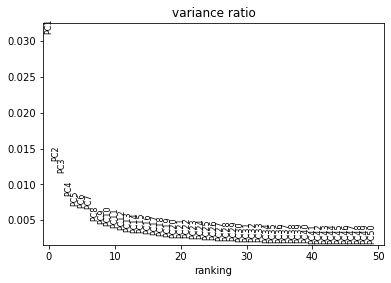

In [17]:
sc.pl.pca_variance_ratio(MOCAdata,n_pcs = 50) 

Based on this plot, we can see that the top 7 PCs retain a lot of information, while other PCs contain pregressivelly less. However, it is still advisable to use more PCs since they might contain information about rare cell types. In this paper, they use 30 PCs for analysis, which is also widely used by other researchers.

To identify genes that contribute most to each PC, we can retreive the loading matrix information.

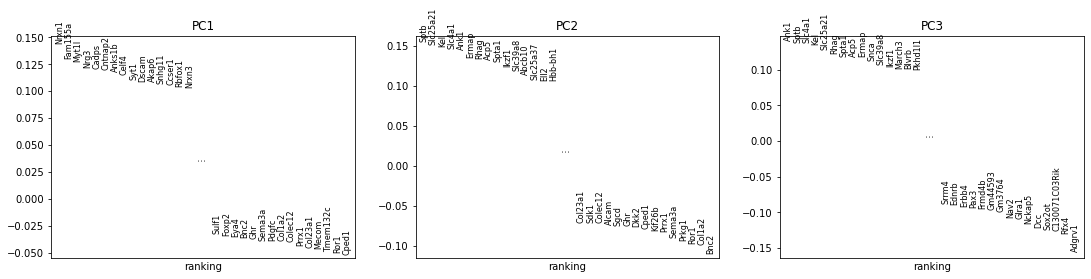

In [19]:
#Plot loadings
sc.pl.pca_loadings(MOCAdata, components=[1,2,3])

In [20]:
MOCAdata

AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

The function to plot loading genes only plots genes on the positive axes. Instead plot as a heatmaps, with genes on both postive and negative side, one per pc, and plot their expression amongst cells ordered by their position along the pc.

In [ ]:
#MOCAdata.write(results_file)

### tSNE

tSNE(t-Stochastic Neighborhood Embedding) (2008, Geoffrey Hinton)
* Non-linear graph-based dimension reduction method 
* Capture local structure rather than globle structure, so the distance in groups are meaningful, but distance between groups are not meaningful.

Problems: 

* tSNE is slow, O(nlogn)
* tSNE doesn't conserve the distance between cluster.


tSNE is a stochastic algorithm which means running the method multiple times on the same dataset will result in different plots. To ensure reproducibility, we fix the "seed" of the random-number generator in the code below so that we always get the same plot (random_state=0 for reproducibility).

(Video : https://www.youtube.com/watch?v=NEaUSP4YerM  [from 1:19])

We can now run BH-tSNE

In [21]:
# tSNE
sc.tl.tsne(MOCAdata, n_jobs = 4 ,n_pcs = 30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:19)


### UMAP

UMAP(Uniform Manifold Approximation and Projection) (2018, Leland Mcinnes)

* Newer & fast, O(n)
* Non-linear graph-based dimension reduction method like tSNE
* Preserves the globle structure better than tSNE

Since UMAP learns the globle data structure and is less dependent on random initiators(like tSNE), it can recreate low dimensional embedding regardless of the dataset size.

(Video : https://www.youtube.com/watch?v=nq6iPZVUxZU)

UMAP is based upon the neighborhood graph.

#### Calculate neighborhood graph

In [22]:
# first with neighbor calculation 
sc.pp.neighbors(MOCAdata, n_neighbors=15, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


Now we can run UMAP.

In [23]:
sc.tl.umap(MOCAdata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


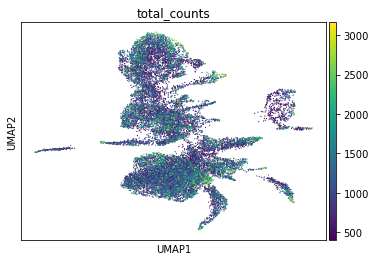

In [24]:
sc.pl.umap(MOCAdata, color='total_counts') 

### Ploting genes of interest
***

Let's plot some marker genes for different celltypes onto the embedding. 

Some genes are: (from table S3)

Markers	| Cell Type
--- | ---
Trp63, Grhl2	| Epithelial cells
Ptprb, Pecam1	| Endothelial cells

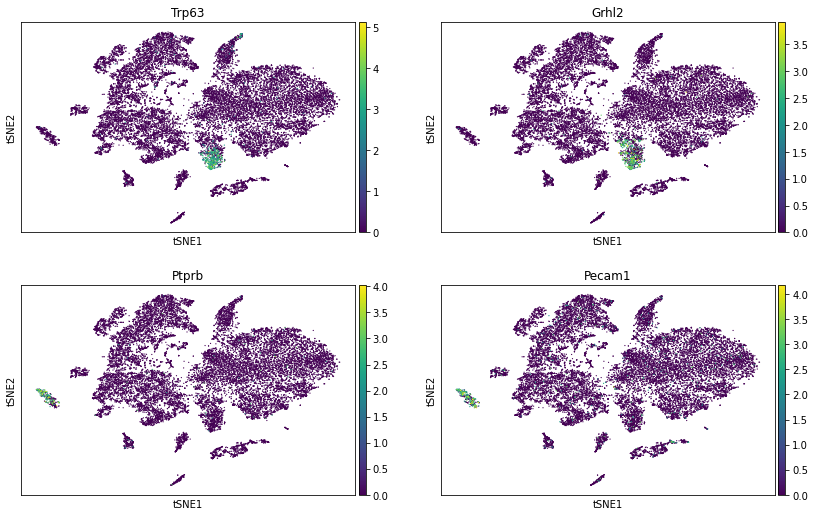

In [25]:
sc.pl.tsne(MOCAdata, color=['Trp63', 'Grhl2','Ptprb', 'Pecam1'],ncols=2)

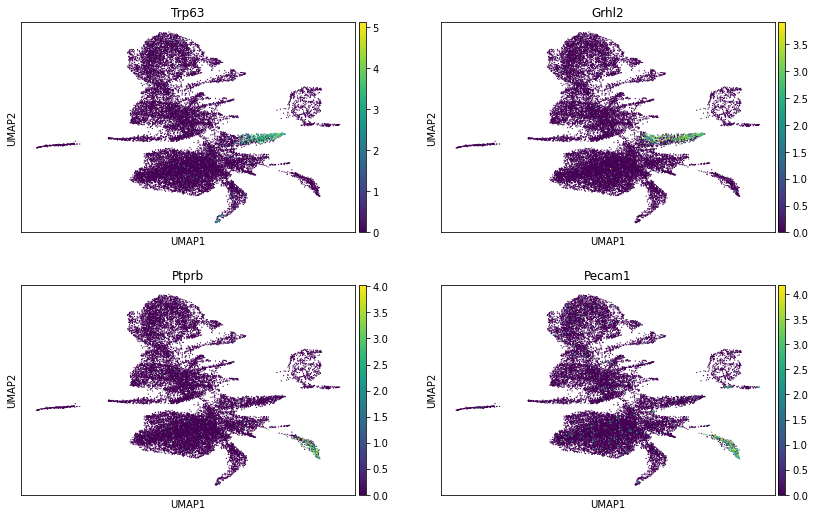

In [26]:
sc.pl.umap(MOCAdata, color=['Trp63', 'Grhl2','Ptprb', 'Pecam1'],ncols=2)

## Clustering

Diverse types of clustering methods are available:

* **k-means** : iteratively identifies k cluster centres (centroids), and each cell is assigned to the closest centroid. 

   - Fast, simple and intuitive.
   
   - The disadvatages of K-means are the method is not guaranteed to find the global minimum (can be overcome by SC3, which is an algrothm framework of k-means clustering.)
   
   - Its bias towards identifying equal-sized clusters, which may result in rare cell types being hidden among a larger group
   
 
   
* **hierarchical clustering**: widely used on scRNA-seq, which sequentially combines individual cells into larger clusters (agglomerative) or divides clusters into smaller groups (divisive). 
    - An important shortcoming is that both time and memory requirements scale at least quadratically with the number of data points, which means that it is prohibitively expensive to use hierarchical clustering for large data sets.


   Louvain & Leiden : graph community detection algorithms.

* **community detection**: As some of the graph data sets available are extremely large, for example, those representing social networks or hyperlinks on the World Wide Web. Several of the algorithms for community detection have been developed with an emphasis on speed and scalability. 
    
    - In contrast to the methods based on hierarchical clustering that return the partitions at all levels, most graph-based methods return only a single solution, which allows for faster run times. 
    
    - An advantage is that most graph-based methods do not require the user to specify the number of clusters to identify, instead employing indirect resolution parameters. 
    
    - **Louvain** algorithm has been widely applied to scRNA-seq data, despite many others being available, such as Leiden.

    - **Leiden** does not yield arbitrarily badly connected communities compared while Louvain does.
    
    - Louvain is the default algorithm in Seurat package in R, while Leiden is recommend by Scanpy package in Python.

References:

1. Challenges in unsupervised clustering of single-cell RNA-seq data, https://www.nature.com/articles/s41576-018-0088-9

2. From Louvain to Leiden: guaranteeing well-connected communities, https://www.nature.com/articles/s41598-019-41695-z

One thing virtually all clustering or community detection methods have in common is some flavor of a **resolution** parameter. This parameter controls how fine- or coarse-grained the inferred clusters are.

Today we will use the scanpy enbedding to perform the clustering using graph community detection algorithms.

In [27]:
sc.tl.louvain(MOCAdata,resolution=1.5) # default resolution is 1, this paper used 1.5

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)


In [28]:
sc.tl.leiden(MOCAdata,resolution=1.5)

running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [29]:
plt.rcParams['figure.figsize'] = (5,5)

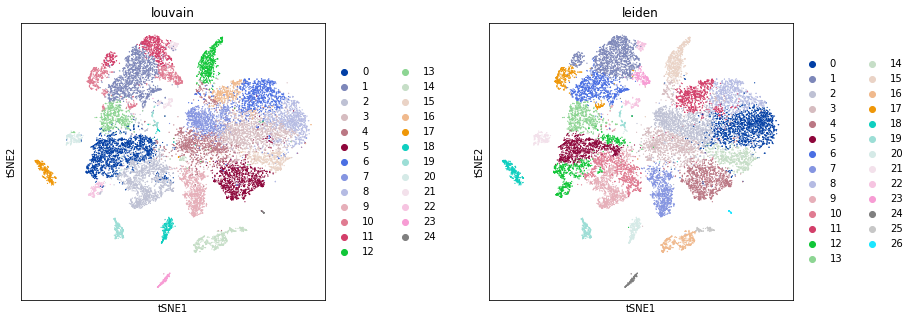

In [30]:
sc.pl.tsne(MOCAdata, color=['louvain','leiden'], wspace = 0.4)

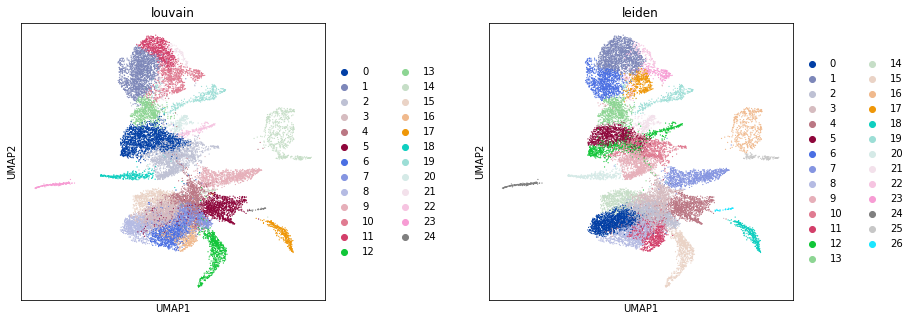

In [31]:
sc.pl.umap(MOCAdata, color=['louvain','leiden'],wspace = 0.4)

Try different resolution

In [32]:
sc.tl.louvain(MOCAdata, key_added = "louvain_1.0") # default resolution in 1.0
sc.tl.louvain(MOCAdata, resolution = 0.6, key_added = "louvain_0.6")
sc.tl.louvain(MOCAdata, resolution = 0.4, key_added = "louvain_0.4")
sc.tl.louvain(MOCAdata, resolution = 1.4, key_added = "louvain_1.4")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain_1.0', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_0.6', the cluster labels (adata.obs, categorical) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_0.4', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain_1.4', the cluster labels (adata.obs, categorical) (0:00:03)


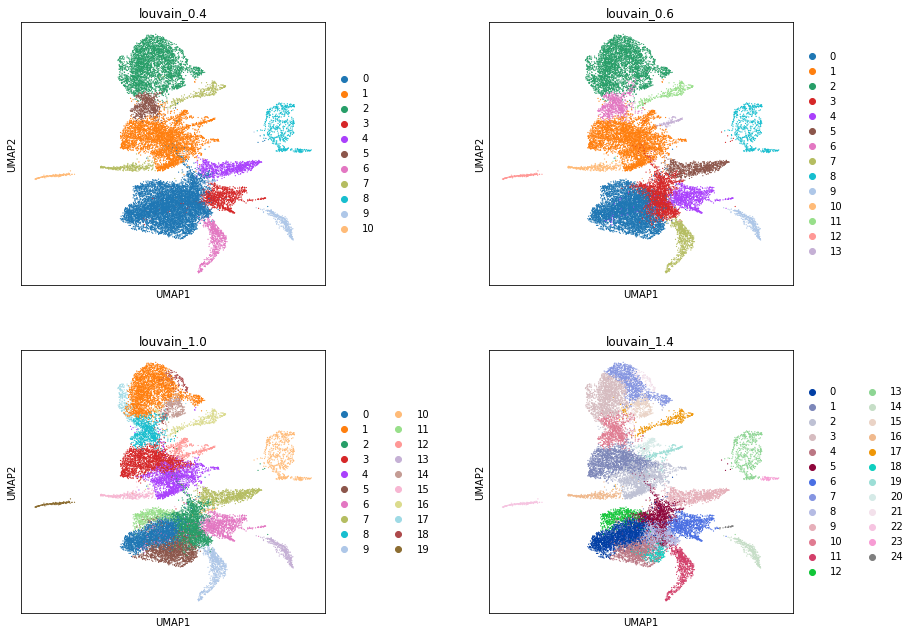

In [33]:
sc.pl.umap(MOCAdata, color=['louvain_0.4', 'louvain_0.6', 'louvain_1.0','louvain_1.4'],wspace = 0.4,ncols=2)

Plot the clusters, as you can see, with increased resolution, we get higher number of clusters.

## Finding marker genes & cluster annotation 

Now that we've assigned cells into clusters, we'd like to understand what makes each cluster different from other cells in the dataset, or to annotate clusters according to their cell types.


There are several approaches to this task:

* Look for upregulation of marker genes for cell types of interest (compared to the rest of the dataset)
* Compare the complete gene expression profiles between groups
* Use automated methods to compare cells of interest to databases of cell type expression profiles to combine clustering and annotation.

Automated methods are a promising advance, but are not yet able to replace careful human curation.

For well-defined cell types, we expect marker genes to show large differences in expression between the cell type of interest and the rest of the dataset.

### Finding marker genes

Scanpy has a very useful function for repeating this process of subsetting the dataset to one group and comparing it to the rest of the dataset. It then returns the genes that are most differentially expressed between that group and all others.


Highly differential genes is performed with the function rank_genes_group. The default method to compute differential expression is the t-test_overestim_var. Other implemented methods are: logreg, t-test and wilcoxon.

(By default, the .raw attribute of AnnData is used. it can be changed by setting use_raw=False.)



### T-test

ranking genes
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


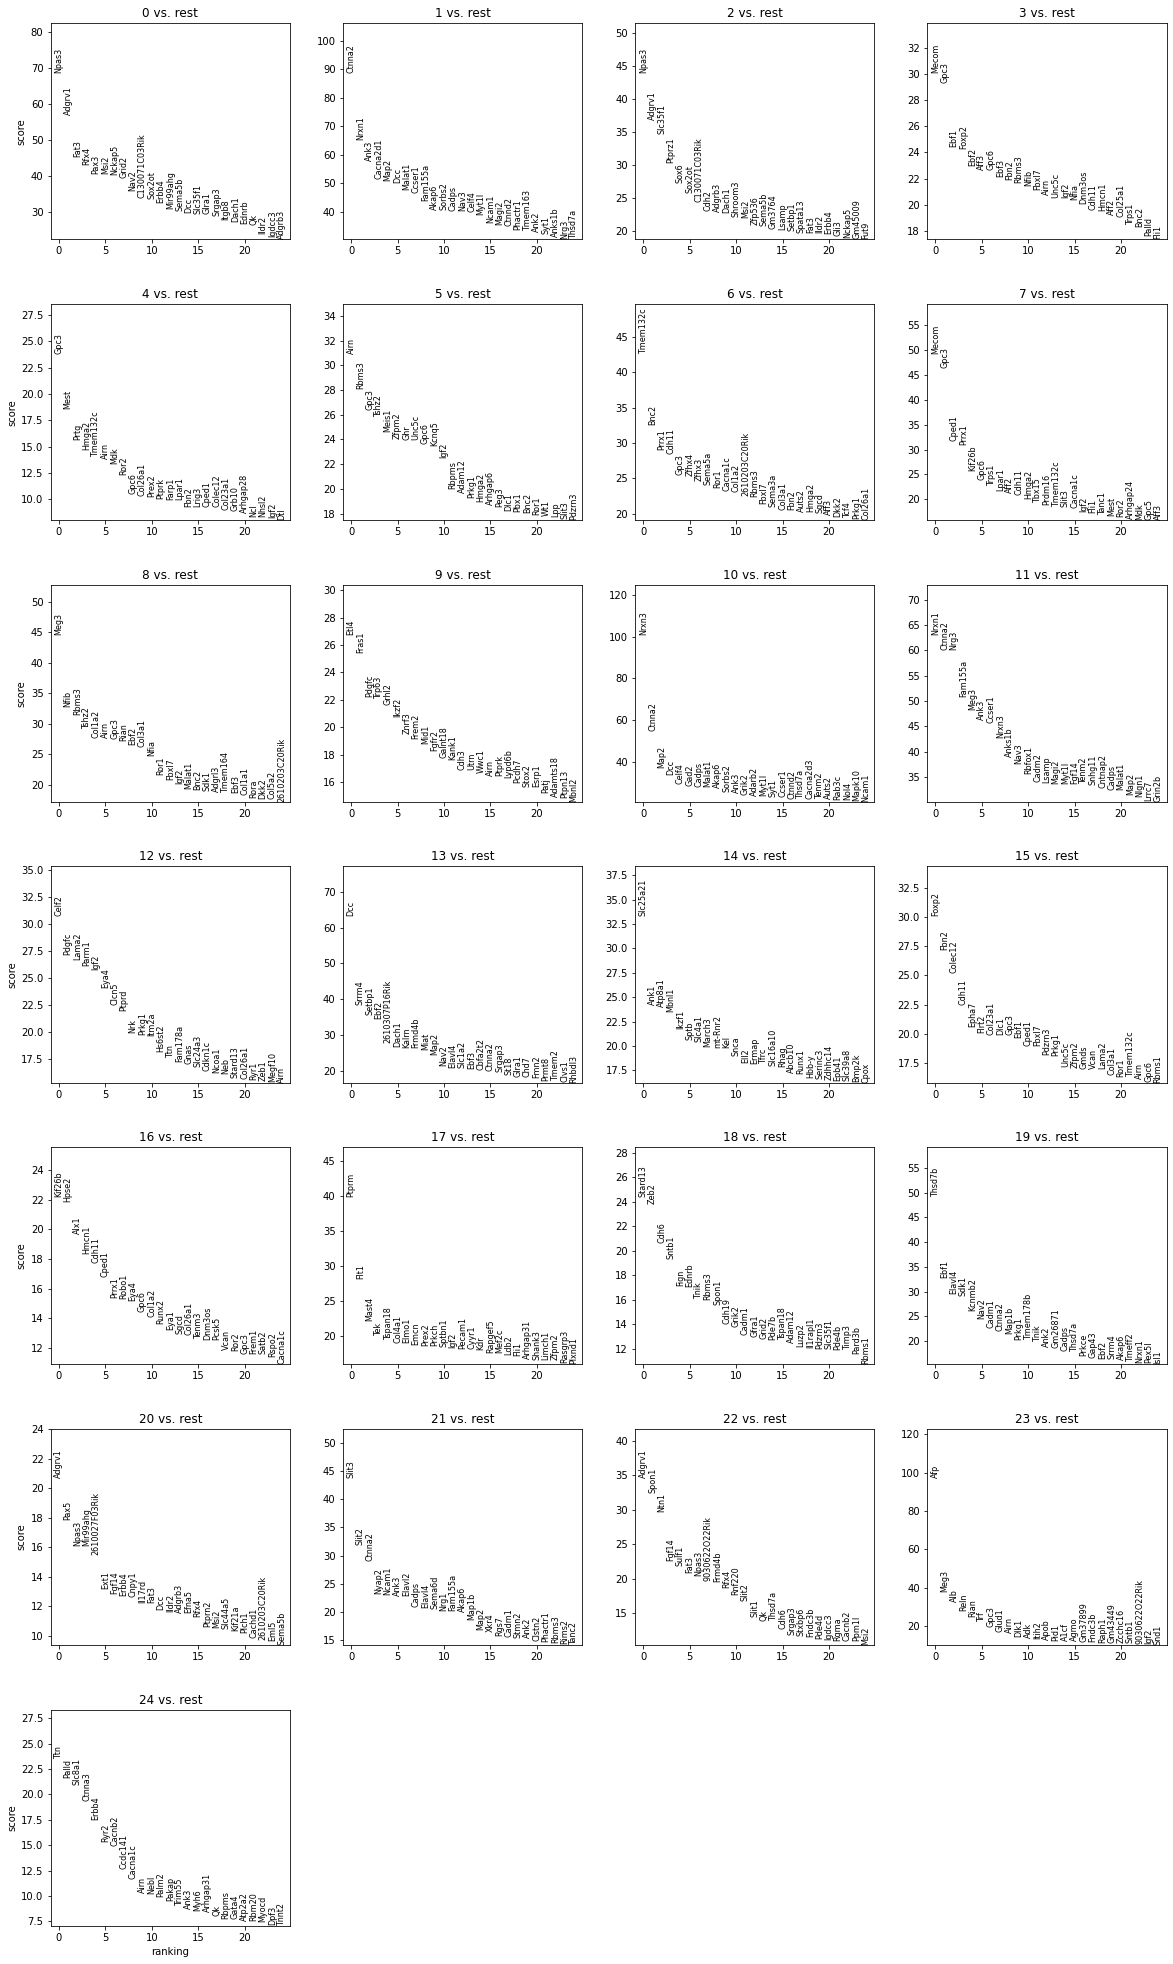

In [34]:
sc.tl.rank_genes_groups(MOCAdata, 'louvain', method='t-test',key_added = "t-test")
sc.pl.rank_genes_groups(MOCAdata, n_genes=25, sharey=False, key = "t-test")

In [ ]:
MOCAdata

In [35]:
result = MOCAdata.uns['t-test']
groups = result['names'].dtype.names
tb_gene_all = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})
tb_gene_all.to_csv("./tb_gene_all.csv",sep="\t")
tb_gene_all.head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,20_n,20_p,21_n,21_p,22_n,22_p,23_n,23_p,24_n,24_p
0,Npas3,0.000000e+00,Ctnna2,0.000000e+00,Npas3,1.575927e-299,Mecom,1.229856e-160,Gpc3,1.494301e-105,...,Adgrv1,4.138405e-55,Slit3,3.875822e-114,Adgrv1,1.716331e-87,Afp,1.916390e-149,Ttn,9.820003e-22
1,Adgrv1,0.000000e+00,Nrxn1,0.000000e+00,Adgrv1,1.288556e-224,Gpc3,1.625585e-156,Mest,5.117501e-69,...,Pax5,1.011424e-45,Slit2,4.243742e-86,Spon1,5.123003e-82,Meg3,8.937832e-87,Palld,8.534862e-21
2,Fat3,2.305113e-319,Ank3,0.000000e+00,Slc35f1,1.319137e-204,Ebf1,6.490095e-114,Prtg,9.322033e-51,...,Npas3,3.319086e-40,Ctnna2,2.727916e-79,Ntn1,1.476689e-75,Alb,4.746843e-74,Slc8a1,2.531164e-20
3,Rfx4,8.670932e-285,Cacna2d1,0.000000e+00,Ptprz1,7.672344e-164,Foxp2,1.619802e-112,Hmga2,1.066807e-45,...,Mir99ahg,2.622628e-40,Nyap2,3.775111e-61,Fgf14,2.367334e-57,Reln,1.316616e-64,Ctnna3,3.177404e-19
4,Pax3,4.261919e-262,Map2,0.000000e+00,Sox6,7.133377e-140,Ebf2,2.320338e-102,Tmem132c,9.895874e-42,...,2610027F03Rik,1.123125e-37,Ncam1,1.211822e-61,Sulf1,2.643315e-55,Rian,5.375754e-58,Erbb4,5.619802e-18
5,Msi2,4.118330e-275,Dcc,0.000000e+00,Sox2ot,2.361330e-125,Aff3,1.474112e-100,Airn,7.469114e-41,...,Ext1,2.948019e-30,Ank3,3.645723e-61,Fat3,7.714000e-53,Trf,4.721156e-52,Ryr2,2.908370e-16
6,Nckap5,1.841300e-262,Malat1,0.000000e+00,C130071C03Rik,1.325363e-114,Gpc6,4.174980e-101,Mdk,1.971026e-38,...,Fgf14,4.196979e-29,Elavl2,3.067946e-60,Npas3,1.440215e-51,Gpc3,6.569069e-46,Cacnb2,5.173035e-16
7,Grid2,2.103915e-254,Ccser1,1.489142e-317,Cdh2,2.628068e-105,Ebf3,4.190860e-96,Ror2,4.659683e-33,...,Erbb4,1.631939e-28,Cadps,9.158745e-55,9030622O22Rik,1.060973e-48,Glud1,8.890094e-38,Ccdc141,5.477616e-14
8,Nav2,3.827269e-222,Fam155a,3.607096e-290,Adgrb3,7.550242e-104,Fbn2,3.033791e-94,Gpc6,4.561049e-25,...,Cnpy1,2.378085e-28,Elavl4,7.817030e-54,Frmd4b,2.533277e-48,Airn,1.085468e-37,Cacna1c,4.465465e-13
9,C130071C03Rik,3.942882e-201,Akap6,4.209237e-262,Dach1,3.820677e-102,Rbms3,3.723422e-93,Col26a1,6.413526e-24,...,Il17rd,4.765287e-27,Sema6d,3.583457e-53,Rfx4,9.476560e-46,Dlk1,7.854923e-31,Airn,9.784499e-12


### Wilcoxon rank-sum

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)


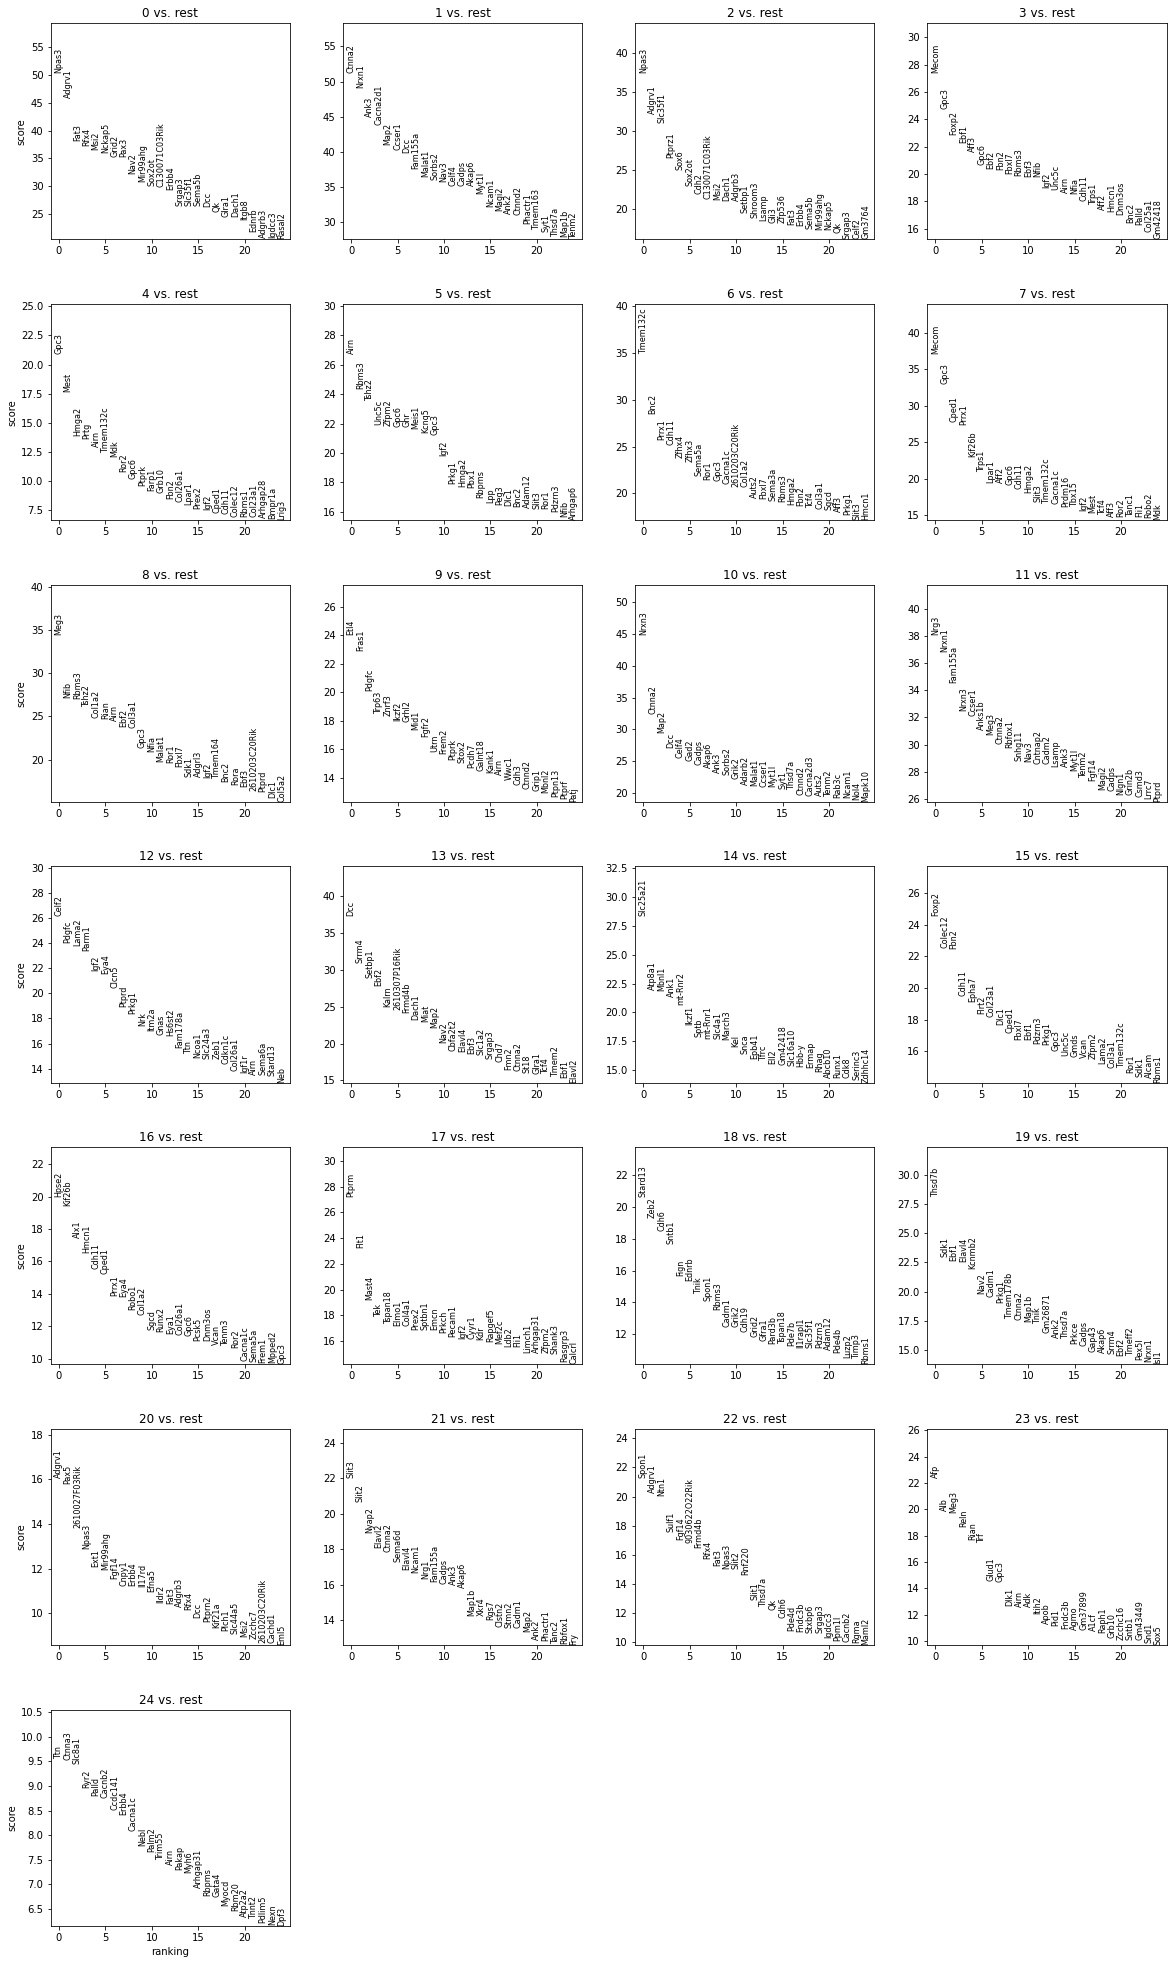

In [36]:
sc.tl.rank_genes_groups(MOCAdata, 'louvain', method='wilcoxon',key_added = "wilcoxon")
sc.pl.rank_genes_groups(MOCAdata, n_genes=25, sharey=False, key = "wilcoxon")

In [37]:
result = MOCAdata.uns['wilcoxon']
groups = result['names'].dtype.names
gene_top10_tb = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)
gene_top10_tb

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,20_n,20_p,21_n,21_p,22_n,22_p,23_n,23_p,24_n,24_p
0,Npas3,0.000000e+00,Ctnna2,0.000000e+00,Npas3,1.404382e-306,Mecom,5.378600e-165,Gpc3,6.896019e-97,...,Adgrv1,6.162938e-58,Slit3,3.431403e-107,Spon1,3.717097e-100,Afp,1.452536e-110,Ttn,1.465050e-21
1,Adgrv1,0.000000e+00,Nrxn1,0.000000e+00,Adgrv1,2.869064e-226,Gpc3,2.035893e-135,Mest,7.201632e-70,...,Pax5,3.728991e-56,Slit2,9.610842e-95,Adgrv1,7.435017e-91,Alb,3.804268e-88,Ctnna3,1.650261e-21
2,Fat3,0.000000e+00,Ank3,0.000000e+00,Slc35f1,7.466476e-211,Foxp2,8.026758e-116,Hmga2,6.299987e-44,...,2610027F03Rik,2.303858e-43,Nyap2,1.316799e-79,Ntn1,5.177828e-89,Meg3,1.712951e-86,Slc8a1,3.345783e-21
3,Rfx4,4.682499e-303,Cacna2d1,0.000000e+00,Ptprz1,6.084400e-155,Ebf1,3.831140e-110,Prtg,6.544923e-42,...,Npas3,7.304054e-38,Elavl2,8.296329e-73,Sulf1,7.243150e-69,Reln,6.835004e-78,Ryr2,3.310693e-19
4,Msi2,1.440838e-292,Map2,0.000000e+00,Sox6,7.676793e-138,Aff3,8.628834e-104,Airn,5.059669e-38,...,Ext1,1.829230e-33,Ctnna2,2.747613e-71,Fgf14,6.967068e-65,Rian,5.838227e-70,Palld,1.347490e-18
5,Nckap5,1.896418e-282,Ccser1,0.000000e+00,Sox2ot,9.471807e-116,Gpc6,1.058872e-94,Tmem132c,2.935514e-35,...,Mir99ahg,9.567409e-33,Sema6d,4.803187e-67,9030622O22Rik,2.345415e-63,Trf,1.996543e-68,Cacnb2,2.155835e-18
6,Grid2,6.774727e-273,Dcc,0.000000e+00,Cdh2,1.190838e-105,Ebf2,2.375779e-92,Mdk,2.886341e-33,...,Fgf14,8.128476e-31,Elavl4,1.318478e-63,Frmd4b,4.289482e-61,Glud1,4.537206e-48,Ccdc141,1.680091e-17
7,Pax3,3.379097e-272,Fam155a,1.867499e-309,C130071C03Rik,3.760236e-100,Fbn2,3.138935e-91,Ror2,3.536042e-27,...,Cnpy1,2.715010e-29,Ncam1,3.465649e-62,Rfx4,1.250842e-55,Gpc3,9.309977e-48,Erbb4,4.206292e-17
8,Nav2,6.382373e-228,Malat1,5.853759e-290,Msi2,2.259141e-99,Fbxl7,7.789612e-89,Gpc6,1.783139e-24,...,Erbb4,3.452081e-29,Nrg1,5.367851e-60,Fat3,2.669225e-52,Dlk1,9.853835e-37,Cacna1c,6.301640e-16
9,Mir99ahg,3.195744e-208,Sorbs2,7.806609e-285,Dach1,8.617502e-98,Rbms3,9.919316e-88,Ptprk,1.477585e-21,...,Il17rd,6.741973e-29,Fam155a,9.682882e-59,Npas3,5.298695e-51,Airn,1.791483e-36,Nebl,7.705001e-15


In [ ]:
# list(gene_top10_tb["0_n"])

# sc.pl.violin(MOCAdata, 
#              list(gene_top10_tb["0_n"]), 
#              groupby='louvain')

In [ ]:
#MOCAdata.write_h5ad('./MOCA_results.h5ad')

In [ ]:
#MOCAdata=sc.read_h5ad('./MOCA_results.h5ad')

In [ ]:
#MOCAdata

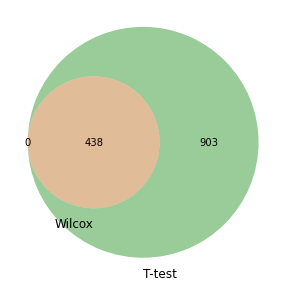

In [38]:
wc = sc.get.rank_genes_groups_df(MOCAdata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(MOCAdata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn2

venn2([set(wc),set(tt)], ('Wilcox','T-test') )
plt.show()    


We can also compare specific cluster.For instance, clusters 1 & 2 have very similar expression profiles

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


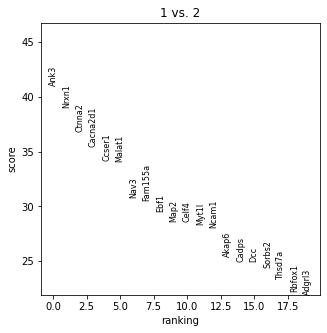

In [39]:
sc.tl.rank_genes_groups(MOCAdata, 'louvain', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(MOCAdata, groups=['1'], n_genes=20)

### Cluster annotation

Celltype prediction can either be performed on indiviudal cells where each cell gets a predicted celltype label, or on the level of clusters. All methods are based on similarity to other datasets, single cell or sorted bulk RNAseq, or uses know marker genes for each celltype.

There are multiple different methods to predict celltypes, here we will just cover the simplest way, use know marker genes to do the cluster annotation.

* Trp63, Grhl2  -> Epithelial cells
* Ptprb, Pecam1	 ->Endothelial cells

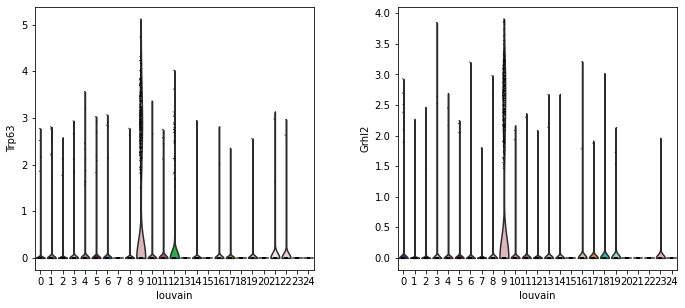

In [40]:
sc.pl.violin(MOCAdata, ['Trp63', 'Grhl2'], groupby='louvain')
    
# cluster 9 -> Epithelial cells

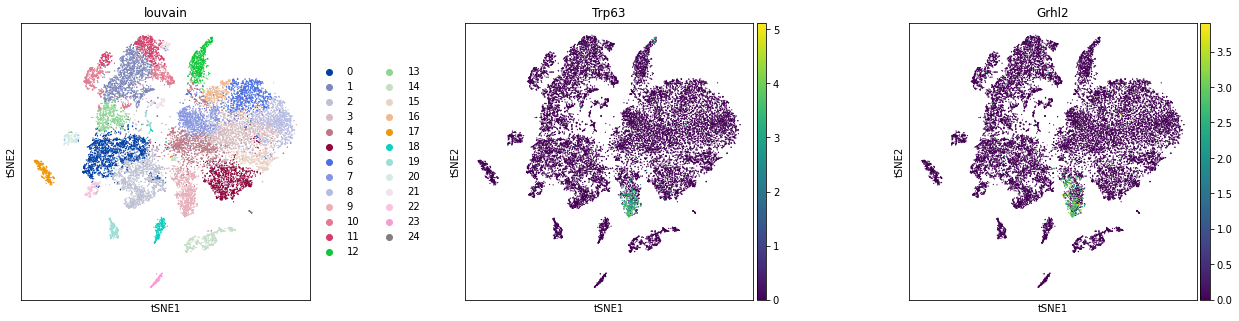

In [41]:
sc.pl.tsne(MOCAdata, color=['louvain', 'Trp63', 'Grhl2'], wspace = 0.4)

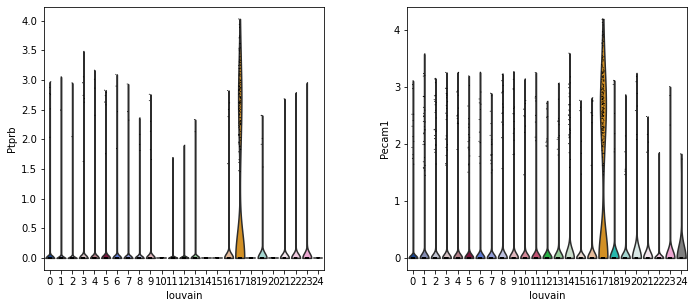

In [42]:
sc.pl.violin(MOCAdata, ['Ptprb', 'Pecam1'], groupby='louvain')

# cluster 9 -> Endothelial cells

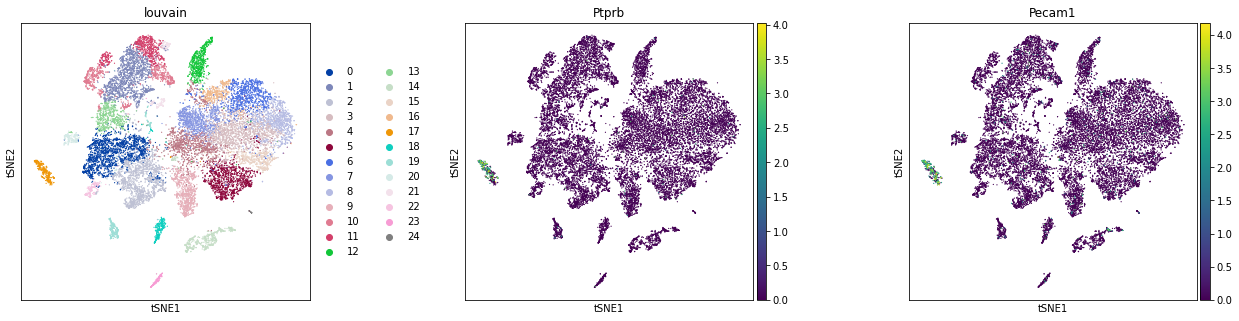

In [43]:
sc.pl.tsne(MOCAdata, color=['louvain', 'Ptprb', 'Pecam1'], wspace = 0.4)

In [45]:
tb_marker = pd.read_table("./datasets/cell_marker.xls")
map_marker =dict( (row['Cell type'],row['Markers'].split(", ")) 
                                  for index,row in tb_marker.iterrows())

In [ ]:
#dict((kk,map_marker[kk]) for kk in ['Cardiac muscle lineages',
#                                    'Isthmic organizer cells',
#                                    ])

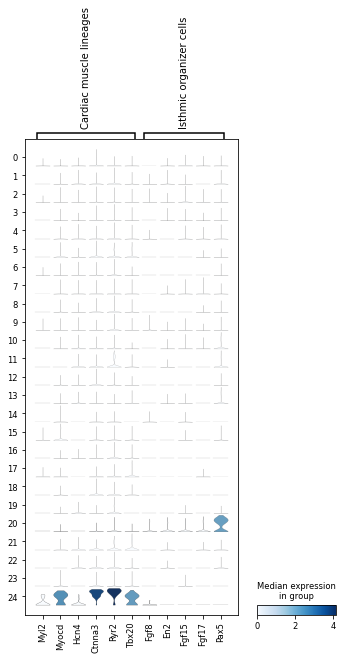

In [46]:
sc.pl.stacked_violin(MOCAdata, 
                     dict((kk,map_marker[kk]) 
                          for kk in ['Cardiac muscle lineages',
                                     'Isthmic organizer cells',
                                     ]), 
                     groupby='louvain');

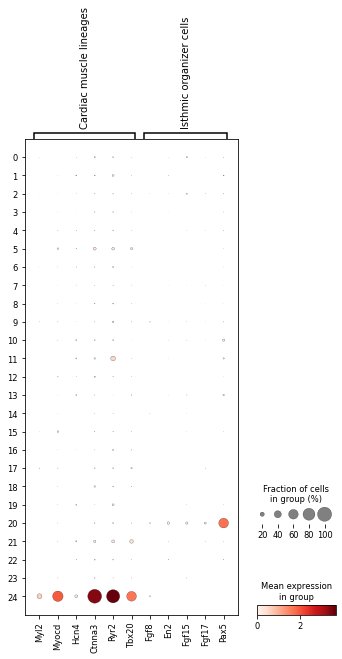

In [47]:
sc.pl.dotplot(MOCAdata, 
              dict((kk,map_marker[kk]) 
                          for kk in ['Cardiac muscle lineages',
                                     'Isthmic organizer cells',
                                     ]), 
              groupby='louvain');

In [48]:
marker_genes = {'Epithelial cells': 
                ['Trp63', 'Grhl2'],
                'Endothelial cells' : 
                ['Ptprb', 'Pecam1'],
                'Cardiac muscle lineages' : 
                ['Myocd','Ctnna3','Ryr2','Tbx20'],
                'Isthmic organizer cells' :
                ['Pax5'],
               }

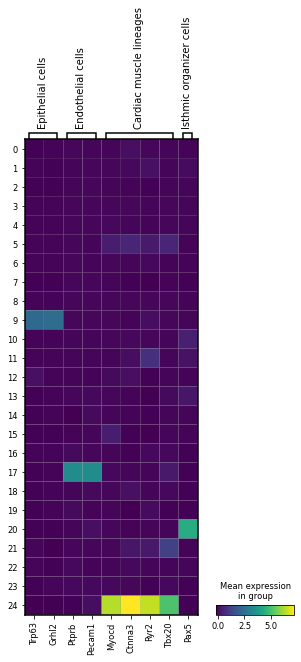

In [49]:
sc.pl.matrixplot(MOCAdata, marker_genes, groupby='louvain', use_raw=False)

In [ ]:
celltype = {'9':'Epithelial cells',
            '17':'Endothelial cells',
            '24':'Cardiac muscle lineages',
            '3':'Isthmic organizer cells',}

MOCAdata.obs['celltype major']=MOCAdata.obs['louvain'].map(celltype).astype('category')

In [ ]:
sc.pl.tsne(MOCAdata, color=['celltype major'])

#### More ways for celltype prediction : 
* Using **scanorama** for integration, and then do label transfer based on closest neighbors.
* Using **ingest** to project the data onto the reference data and transfer labels.

### sub-clusters

In [ ]:
# sub_data = MOCAdata[MOCAdata.obs['louvain']=='0']

In [ ]:
# sub_data = MOCAdata[MOCAdata.obs['louvain'].isin(['0','1'])]

## Save data

In [ ]:
MOCAdata.write_h5ad('./MOCA_results.h5ad') # the file that will store the analysis results

## Recommended reading

https://scrnaseq-course.cog.sanger.ac.uk/website/index.html
https://github.com/chanzuckerberg/scRNA-python-workshop
    
https://www.embopress.org/doi/full/10.15252/msb.20188746